# Normalizing Flows using Pyro

## Approximating Lognormal distribution

In [9]:
# Lognormal
## X \sim N(0,1)
## Y \sim exp(X) = lognormal(0,1)

import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T # A variety of bijective transformations live in the pyro.distributions.transforms module
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)


# First, we create a base distribution for X. In this case, we'll use the standard normal:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))

# Next, we define the transform (here, the exponential function) and the distribution Y:
exp_transform = T.ExpTransform()

# Now, we can simply apply the transform to the base distribution to create a transformed distribution:
dist_y = dist.TransformedDistribution(dist_x, [exp_transform]) # Note that we don't need to compute the Jacobian ourselves!

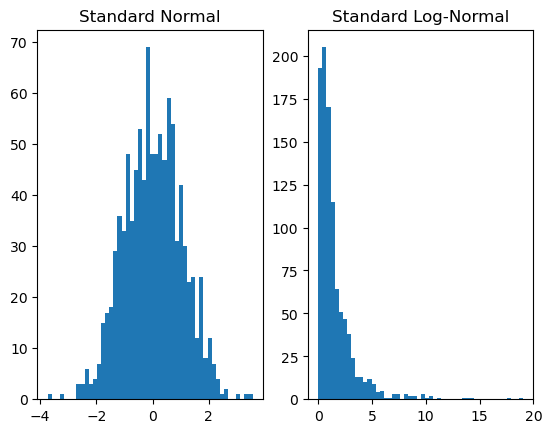

In [10]:
plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Standard Log-Normal')
plt.show()

## Affine Transformation (General Lognormal)

\begin{aligned}
& X \sim \mathcal{N}(0,1) \\
& Y=\exp (\mu+\sigma X)
\end{aligned}

or rather, $Y \sim \log \operatorname{Normal}\left(\mu, \sigma^2\right)$. In Pyro this is accomplished, e.g. for $\mu=3, \sigma=0.5$, as follows:

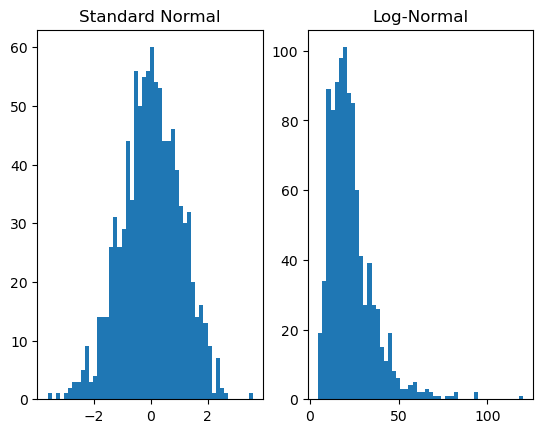

In [8]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

plt.subplot(1, 2, 1)
plt.hist(dist_x.sample([1000]).numpy(), bins=50)
plt.title('Standard Normal')
plt.subplot(1, 2, 2)
plt.hist(dist_y.sample([1000]).numpy(), bins=50)
plt.title('Log-Normal')
plt.show()

# Learnable Transformation

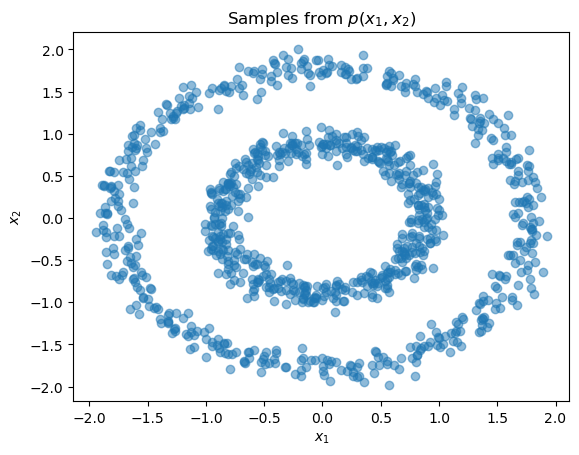

/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


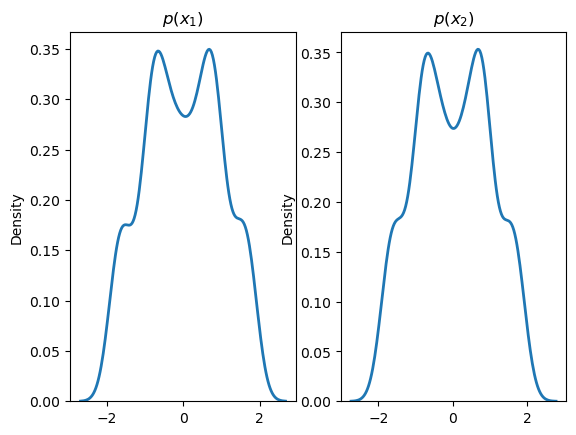

In [11]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

So, how can we approximate such distribution starting from a simple distribution? Using `Lernable Neural Flows`, e.g. Spline Flows, Planar Flows etc.

In [12]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.Spline(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [20]:
%%time
steps = 1 if smoke_test else 5001
print(steps)
dataset = torch.tensor(X, dtype=torch.float) # X is above circular shaped data
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2) # spline transform from T.Spline
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

5001
step: 0, loss: 1.2691271305084229
step: 200, loss: 1.268878698348999
step: 400, loss: 1.2695186138153076
step: 600, loss: 1.2698888778686523
step: 800, loss: 1.2687135934829712
step: 1000, loss: 1.2690436840057373
step: 1200, loss: 1.2699785232543945
step: 1400, loss: 1.268229365348816
step: 1600, loss: 1.2681463956832886
step: 1800, loss: 1.2680391073226929
step: 2000, loss: 1.2670691013336182
step: 2200, loss: 1.2677117586135864
step: 2400, loss: 1.2674962282180786
step: 2600, loss: 1.2656420469284058
step: 2800, loss: 1.2654451131820679
step: 3000, loss: 1.265592098236084
step: 3200, loss: 1.2644994258880615
step: 3400, loss: 1.2676900625228882
step: 3600, loss: 1.2642865180969238
step: 3800, loss: 1.2644460201263428
step: 4000, loss: 1.2647507190704346
step: 4200, loss: 1.2662875652313232
step: 4400, loss: 1.2668585777282715
step: 4600, loss: 1.265407919883728
step: 4800, loss: 1.2641431093215942
step: 5000, loss: 1.2650107145309448
CPU times: user 9.88 s, sys: 2.96 s, total: 

After training is done, let's sample from what we've learn

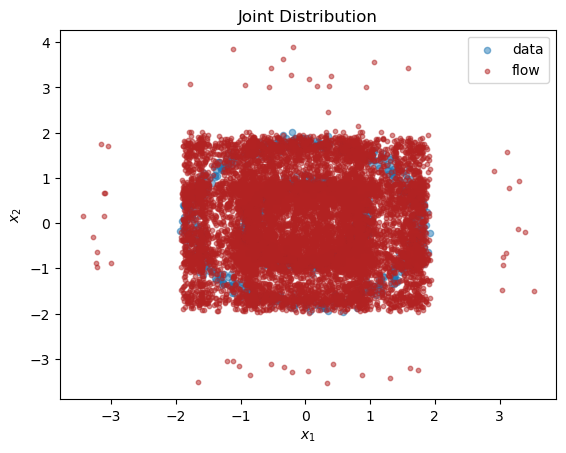

/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

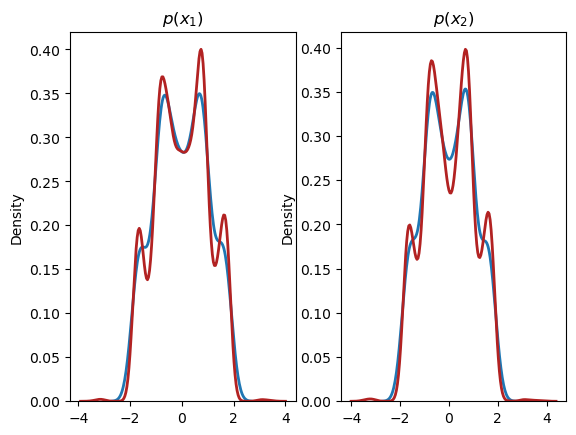

In [21]:
X_flow = flow_dist.sample(torch.Size([10000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5, s=20)  # Adjust the 's' parameter
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5, s=10)  # Adjust the 's' parameter
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

But above transformation learns the `marginal` not the `joint` distribution. To learn the joint distribution, we need to use `Multivariate Transforms`.

The main challenge is in designing parametrizable multivariate bijections that have closed form expressions for both $g$ and $g^{-1}$, a tractable Jacobian whose calculation scales with $O(D)$ rather than $O\left(D^3\right)$, and can express a flexible class of functions.

# Multivariate Transforms in Pyro

The power of Normalizing Flow, however, is most apparent in their ability to model complex high-dimensional distributions with neural networks and Pyro contains several such flows for accomplishing this. Transforms that operate on vectors have the property `transform.event_dim == 1`, transforms on matrices with `transform.event_dim == 2`, and so on. In general, the event_dim property of a transform indicates how many dependent dimensions there are in the output of a transform.



In this section, we show how to use `SplineCoupling` to learn the bivariate toy distribution from our running example. A coupling transform `[8, 9]` divides the input variable into two parts and applies an element-wise bijection to the section half whose parameters are a function of the first. Optionally, an element-wise bijection is also applied to the first half. Dividing the inputs at 

In this section, we show how to use SplineCoupling to learn the bivariate toy distribution from our running example. A coupling transform $[8,9]$ divides the input variable into two parts and applies an element-wise bijection to the section half whose parameters are a function of the first. Optionally, an element-wise bijection is also applied to the first half. Dividing the inputs at $d$, the transform is,
$$
\begin{aligned}
\mathbf{y}_{1: d} & =g_\theta\left(\mathbf{x}_{1: d}\right) \\
\mathbf{y}_{(d+1): D} & =h_\phi\left(\mathbf{x}_{(d+1): D} ; \mathbf{x}_{1: d}\right)
\end{aligned}
$$
where $\mathbf{x}_{1: d}$ represents the first $d$ elements of the inputs, $g_\theta$ is either the identity function or an elementwise bijection parameters $\theta$, and $h_\phi$ is an element-wise bijection whose parameters are a function of $\mathbf{x}_{1: d}$.

This type of transform is easily invertible. We invert the first half, $\mathbf{y}_{1: d}$, then use the resulting $\mathbf{x}_{1: d}$ to evaluate $\phi$ and invert the second half,
$$
\begin{aligned}
\mathbf{x}_{1: d} & =g_\theta^{-1}\left(\mathbf{y}_{1: d}\right) \\
\mathbf{x}_{(d+1): D} & =h_\phi^{-1}\left(\mathbf{y}_{(d+1): D} ; \mathbf{x}_{1: d}\right)
\end{aligned}
$$

In [23]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16) # compare this with `spline_transform = T.Spline(2, count_bins=16)``
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [24]:
%%time
steps = 1 if smoke_test else 5001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=5e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.747011184692383
step: 500, loss: 1.8574262857437134
step: 1000, loss: 1.7706968784332275
step: 1500, loss: 1.735882043838501
step: 2000, loss: 1.7015591859817505
step: 2500, loss: 1.6686867475509644
step: 3000, loss: 1.7192974090576172
step: 3500, loss: 1.6570017337799072
step: 4000, loss: 1.6427690982818604
step: 4500, loss: 1.6524804830551147
step: 5000, loss: 1.656496286392212
CPU times: user 21.8 s, sys: 3.42 s, total: 25.2 s
Wall time: 22.4 s


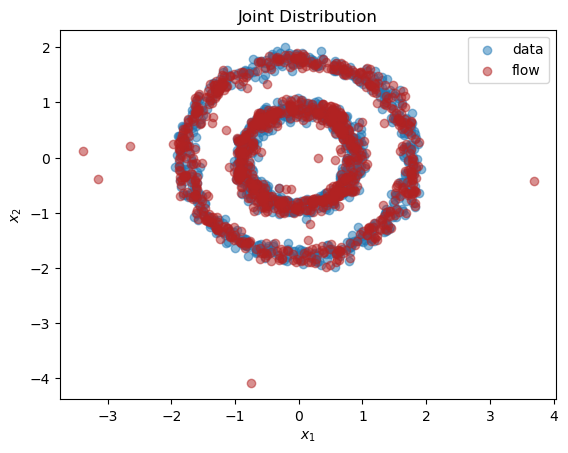

/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

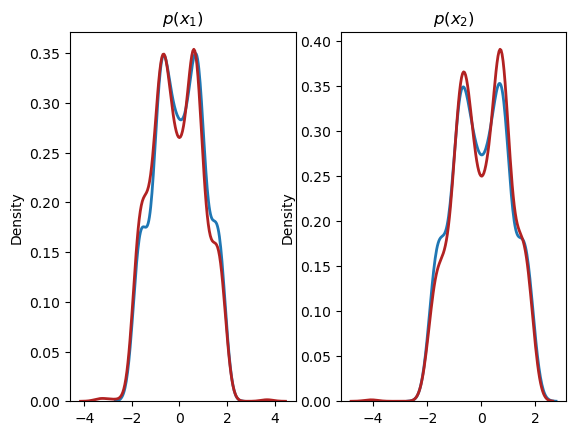

In [27]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()

We see from the output that this normalizing flow has successfully learnt both the univariate marginals and the bivariate distribution.

# Conditional versus Joint Distributions

The theory of Normalizing Flows is easily generalized to conditional distributions. For example, we may wish to learn to generate an object $\mathbf{x}$ conditioned on some context $\mathbf{c}$ using $p_\theta(\mathbf{x} \mid \mathbf{c})$ and observations $\left\{\left(\mathbf{x}_n, \mathbf{c}_n\right)\right\}_{n=1}^N$.

The theory of Normalizing Flows is easily generalized to conditional distributions. We denote the variable to condition on by $C=\mathbf{c} \in \mathbb{R}^M$. A simple multivariate source of noise, for example a standard i.i.d. normal distribution, $X \sim \mathcal{N}\left(\mathbf{0}, I_{D \times D}\right)$, is passed through a vector-valued bijection that also conditions on $C, g: \mathbb{R}^D \times \mathbb{R}^M \rightarrow \mathbb{R}^D$, to produce the more complex transformed variable $Y=g(X ; C=\mathbf{c})$. In practice, this is usually accomplished by making the parameters for a known normalizing flow bijection $g$ the output of a hypernet neural network that inputs $\mathbf{c}$.

The theory of Normalizing Flows is easily generalized to conditional distributions. We denote the variable to condition on by $C=\mathbf{c} \in \mathbb{R}^M$. A simple multivariate source of noise, for example a standard i.i.d. normal distribution, $X \sim \mathcal{N}\left(\mathbf{0}, I_{D \times D}\right)$, is passed through a vector-valued bijection that also conditions on $C, g: \mathbb{R}^D \times \mathbb{R}^M \rightarrow \mathbb{R}^D$, to produce the more complex transformed variable $Y=g(X ; C=\mathbf{c})$. In practice, this is usually accomplished by making the parameters for a known normalizing flow bijection $g$ the output of a hypernet neural network that inputs $\mathbf{c}$.

# Conditional Transforms in Pyro


In this section, we will show how we can learn our toy dataset as the decomposition of the product of a conditional and a univariate distribution,
$$
p\left(x_1, x_2\right)=p\left(x_2 \mid x_1\right) p\left(x_1\right)
$$

In [28]:
dist_base = dist.Normal(torch.zeros(1), torch.ones(1))
x1_transform = T.spline(1)
dist_x1 = dist.TransformedDistribution(dist_base, [x1_transform]) # first learn the transform of x1

In [29]:
x2_transform = T.conditional_spline(1, context_dim=1)
dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base, [x2_transform]) # then learn transform of x2 given x1

In [31]:
%%time
steps = 1 if smoke_test else 5001
modules = torch.nn.ModuleList([x1_transform, x2_transform])
optimizer = torch.optim.Adam(modules.parameters(), lr=3e-3)
x1 = dataset[:,0][:,None]
x2 = dataset[:,1][:,None]
for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(x1)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(x1.detach()).log_prob(x2.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 3.7311387062072754
step: 500, loss: 1.9820141792297363
step: 1000, loss: 1.9248485565185547
step: 1500, loss: 1.8707636594772339
step: 2000, loss: 1.8378572463989258
step: 2500, loss: 1.8711494207382202
step: 3000, loss: 1.8202282190322876
step: 3500, loss: 1.8637140989303589
step: 4000, loss: 1.8324440717697144
step: 4500, loss: 1.8487226963043213
step: 5000, loss: 1.8007686138153076
CPU times: user 19.1 s, sys: 693 ms, total: 19.8 s
Wall time: 19.2 s


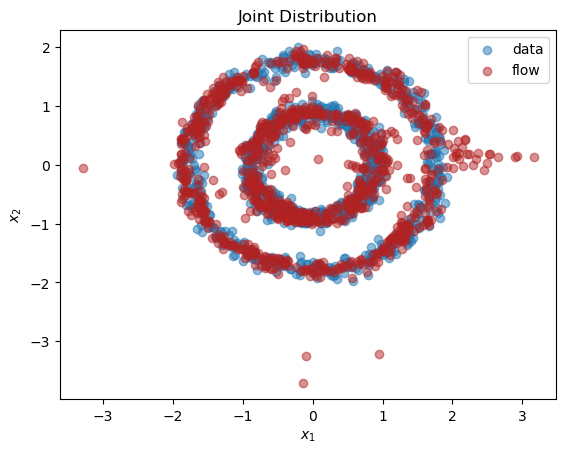

/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/syyun/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with simil

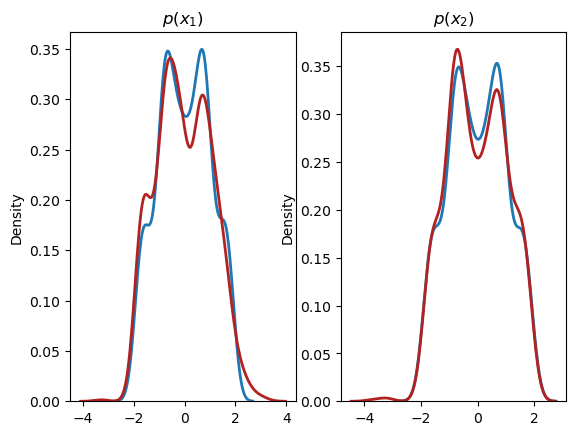

In [32]:
X = torch.cat((x1, x2), dim=-1)
x1_flow = dist_x1.sample(torch.Size([1000,]))
x2_flow = dist_x2_given_x1.condition(x1_flow).sample(torch.Size([1000,]))
X_flow = torch.cat((x1_flow, x2_flow), dim=-1)

plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()